In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
import numpy as np
import keras
from keras import backend as K


In [4]:
import Spectrum
import Dataset


In [3]:
dset = Dataset.Dataset()


In [60]:

def build_input():
    x = keras.layers.Input(shape=(192, 256, 3))
    return x

def build_conv(x, nf, size, stride=1):
    x = keras.layers.Conv2D(nf,
                            (size, size),
                            strides=(stride, stride),
                            kernel_initializer=keras.initializers.RandomNormal(0, 0.02),
                            padding='same')(x)
    return x

def build_resnet(x):
    y = build_conv(x, 256, 3, 1)
    y = build_conv(y, 256, 3, 1)
    return keras.layers.Add()([y, x])

def build_deconv(x, nf, size, stride=2):
    x = keras.layers.Conv2DTranspose(nf, size, strides=(stride, stride), padding='same')(x)
    return x

def build_generator():
    inputs = x = build_input()

    x = build_conv(x, 64, 7)
    x = build_conv(x, 128, 3, 2)
    x = build_conv(x, 256, 3, 2)

    for i in range(6):
        x = build_resnet(x)

    x = build_deconv(x, 128, 3)
    x = build_deconv(x, 64, 3)
    outputs = x = build_conv(x, 3, 7)

    return keras.models.Model(inputs=inputs, outputs=outputs)

def build_discriminator():
    inputs = x = build_input()

    x = build_conv(x, 64, 4, 2)
    x = build_conv(x, 128, 4, 2)
    x = build_conv(x, 256, 4, 2)
    outputs = x = build_conv(x, 1, 4, 2)

    return keras.models.Model(inputs=inputs, outputs=outputs)

def gan_loss(output, target):
    diff = output - target
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims((K.mean(diff ** 2, dims)), 0)

def cycle_loss(cycle, real):
    diff = K.abs(cycle - real)
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims((K.mean(diff ** 2, dims)), 0)

def gen_loss(inputs):
    disc_fake_B, cycle_A, orig_A, disc_fake_A, cycle_B, orig_B = inputs
    gen_A_loss = gan_loss(disc_fake_B, K.ones_like(disc_fake_B))
    gen_B_loss = gan_loss(disc_fake_A, K.ones_like(disc_fake_A))
    cycle_A_loss = cycle_loss(cycle_A, orig_A)
    cycle_B_loss = cycle_loss(cycle_B, orig_B)
    loss = gen_A_loss + gen_B_loss + 10 * (cycle_A_loss + cycle_B_loss)
    return loss

def disc_loss(inputs):
    disc_true, disc_false = inputs
    true_loss = gan_loss(disc_true, K.ones_like(disc_true))
    false_loss = gan_loss(disc_false, K.zeros_like(disc_false))
    loss = 0.5 * (true_loss + false_loss)
    return loss


class CycleGAN:
    def setTrainable(self, gen, discA, discB):
        for layer in self.net_A2B_gen.layers:
            layer.trainable = gen
        for layer in self.net_B2A_gen.layers:
            layer.trainable = gen
        for layer in self.net_A_disc.layers:
            layer.trainable = discA
        for layer in self.net_B_disc.layers:
            layer.trainable = discB

    def __init__(self):
        # Generator and discriminator networks
        self.net_A2B_gen = build_generator()
        self.net_B2A_gen = build_generator()
        self.net_A_disc = build_discriminator()
        self.net_B_disc = build_discriminator()

        orig_A = self.net_A2B_gen.inputs[0]
        orig_B = self.net_B2A_gen.inputs[0]
        fake_B = self.net_A2B_gen.outputs[0]
        fake_A = self.net_B2A_gen.outputs[0]

        # Train function for generators
        disc_fake_B = self.net_B_disc(fake_B)
        cycle_A = self.net_B2A_gen(fake_B)
        disc_fake_A = self.net_A_disc(fake_A)
        cycle_B = self.net_A2B_gen(fake_A)

        self.setTrainable(True, False, False)

        inputs = [orig_A, orig_B]
        outputs = [disc_fake_B, cycle_A, orig_A, disc_fake_A, cycle_B, orig_B]
        outputs = keras.layers.Lambda(gen_loss)(outputs)
        self.train_gen = keras.models.Model(inputs, outputs)
        adam_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, beta_2=0.999,
                                         epsilon=None, decay=0.0)
        self.train_gen.compile(adam_opt, 'mae')

        # Train function for discriminator A
        disc_A = self.net_A_disc(orig_A)
        false_A = build_input()
        disc_false_A = self.net_A_disc(false_A)
        self.setTrainable(False, True, False)
        inputs = [orig_A, false_A]
        outputs = keras.layers.Lambda(disc_loss)([disc_A, disc_false_A])
        self.train_disc_A = keras.models.Model(inputs, outputs)
        self.train_disc_A.compile(adam_opt, 'mae')

        # Train function for discriminator b
        disc_B = self.net_B_disc(orig_B)
        false_B = build_input()
        disc_false_B = self.net_B_disc(false_B)
        self.setTrainable(False, False, True)
        inputs = [orig_B, false_B]
        outputs = keras.layers.Lambda(disc_loss)([disc_B, disc_false_B])
        self.train_disc_B = keras.models.Model(inputs, outputs)
        self.train_disc_B.compile(adam_opt, 'mae')




cgan = CycleGAN()



In [76]:
model.save('gurer1.h5')

In [9]:
b=model.predict(dset.train[0][121:122])

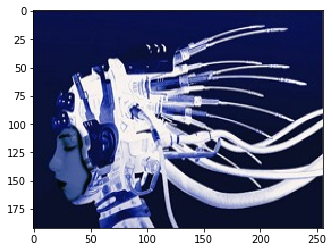

In [31]:
plot.imshow(dset.train[0][121])

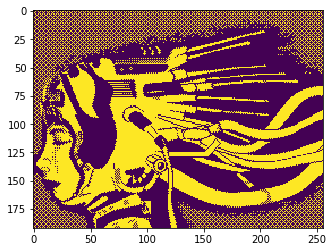

In [32]:
plot.imshow(dset.train[1][121].reshape(192,256))

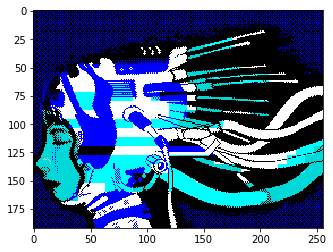

In [33]:
scr = Spectrum.nn_to_scr(dset.train[1][121],dset.train[2][121])
plot.imshow(Spectrum.scr_to_image(scr))

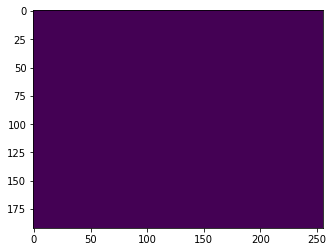

In [10]:
plot.imshow(b[0].reshape(192,256))

In [86]:
np.max(b),np.max(a)

(0.48088044, 0.8189197)

In [11]:
np.median(b)

1.0

In [107]:
def nn_to_scr(bitmap, attr):
    data = bytearray(6912)
    for x in range(0, Spectrum.screen_width):
        for y in range(0, Spectrum.screen_height):
            if bitmap[y, x] < 0.438:
                continue
            third = y // 64
            ty = y % 64
            block = ty % 8
            by = ty // 8
            pos = third * 2048 + block * 256 + by * 32 + x // 8
            bit = 7 - (x % 8)
            data[pos] |= 1 << bit
    for x in range(0, Spectrum.attr_width):
        for y in range(0, Spectrum.attr_height):
            b = 0
            if attr[y, x, 0] >= 0.5:
                b |= 0x40
            ink = np.argmax(attr[y,x, 1:9])
            paper = np.argmax(attr[y, x, 9:])
            ink = 2
            paper=0
            b |= ink
            b |= paper << 3
            data[6144 + x + y * 32] = b
    return data
